# Infiltration excess
    -Author: Niccolò Tubini and Riccardo Rigon
    -License: Creative Commons 4.0   
_____   

## Table of Contents

* [Expectations](#Expectations)
* [Meta data](#Meta_data)
* [Reference](#Reference)
* [Description](#Description")
* [Visualize the output](#Visualize-the-output)
    * [Comparison between rainfall intensity and infiltration](#Comparison-between-rainfall-intensity-and-infiltration)
        * ['Wet' case](#'Wet'-case)
        * ['Dry' case](#'Dry'-case)
    * [Comparison between the capillary gradient field for the 'wet' and 'dry' case](#Comparison-between-the-capillary-gradient-field-for-the-'wet'-and-'dry'-soil)
        * [Compute the capillary gradient field for the 'wet' and 'dry' soil](#Compute-the-capillary-gradient-field-for-the-'wet'-and-'dry'-soil)
    * [Comparison between the hydraulic conductivity field for the 'wet' and 'dry' soil](#Comparison-between-the-hydraulic-conductivity-field-for-the-'wet'-and-'dry'-soil)
        * [Compute the hydraulic conductivity field for the 'wet' and 'dry' soil](#Compute-the-hydraulic-conductivity-field-for-the-'wet'-and-'dry'-soil)


## Expectations
The definition of the surface boundary condition is a nontrivial task since it is a system-dependent boundary condition. The infiltration rate through the soil surface depends on precipitation, rainfall intensity $J$, and on the moisture condition of the soil. Because of this, the surface boundary condition may change from the Dirichlet type - prescribed water suction - to the Neumann type - prescribed flux - and vice-versa. The works by Horton (1933) and Dunne and Black (1970) establish the conceptual framework to explain the runoff generation. The infiltration excess or Horton runoff occurs when the rainfall intensity is larger than infiltration capacity of the soil:
$$J > \big|-K(\psi)\dfrac{\partial \psi}{\partial z} - K(\psi)\big|\Big|_{z=0} $$
Infiltration excess is most commonly observed with short-duration, intense rainfall.

In this notebook we present two test cases simulating the infiltration excess process.

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| WHETGEO-1D |
| Model version  |  v0.98 |
| Model reference | Tubini and Rigon (2021) |
| Grid input file (a) | `data/Grid_NetCDF/HortonRunOff_dry.nc` |
| Grid input file (b) | `data/Grid_NetCDF/HortonRunOff_wet.nc` |
| Surface boundary condition file | `data/Timeseries/HortonRunOff_precip.csv` |
| Bottom boundary condition file (a) | `data/Timeseries/HortonRunOff_Dirichlet_100.csv` |
| Bottom boundary condition file (b) | `data/Timeseries/HortonRunOff_Dirichlet_0.csv` |
| .sim file (a) | `simulation/Richards1D_HortonRunOff_dry_soil.sim` |
| .sim file (b) | `simulation/Richards1D_HortonRunOff_wet_soil.sim` |

## Reference
Horton, R. E.: The role of infiltration in the hydrologic cycle, Eos, Transactions American Geophysical Union, 14, 446–460, 1933.


In [ ]:
import os
import pandas as pd
import numpy as np
# import datetime as datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as cl 
from matplotlib import rc
import matplotlib.style as style 
%matplotlib inline

import math
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
}

plt.rcParams.update(nice_fonts)

linewidth_n = 0.8
linewidth_a = 0.9
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ece7f2","#d0d1e6","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#023858"])
project_path = os.path.dirname(os.getcwd())

# Description

In this numerical experiment we consider a homogeneous soil of 3 [m] depth. Soil hydraulic properties are described with the Van Genuchten’s model 

|$\theta_r$ [-]|$\theta_s$ [-]|$\alpha$ [m$^{-1}$] |$n$ [-]|$K_s$ [m s$^{-1}$]   |  
|--------------|--------------|--------------------|-------|---------------------|
|$0.089$       |$0.43$        |$1.0$               |$1.23$ |$1.9447 \times 10^{-7}$|

The surface boundary condition is a synthetic
rainfall, lasting $15$ [min] with constant intensity of $0.028$ [mm s$^{-1}$].

Here we consider two different intial conditions. In the first case, the initial condition is assumed to be hydrostatic with $\psi=0$ [m] at the bottom. We refer to this simulation as 'wet'. In the second case, the initial condition is assumed to be hydrostatic with $\psi=-100$ [m] at the bottom. We refer to this simulation as 'dry'.

# Visualize output

In [2]:
os.chdir(project_path+'/output')

In [3]:
ds_dry = xr.open_dataset("Sim_HortonRunOff_dry_0000.nc")
# print(ds_d.keys)

ds_wet = xr.open_dataset("Sim_HortonRunOff_wet_0000.nc")



## Comparison between rainfall intensity and infiltration

### 'Wet' case

Panel (a) shows a comparison between the rainfall intensity $J$ and actual soil infiltration $i$. The rainfall intensity exceeds the
actual infiltration rate so water builds up at the soil surface (blue line). Panel (b) shows the time evolution of the water suction within the
soil. From the numerical point of view, as water builds up at the soil surface it would be necessary to switch the boundary condition, from
Neumann type to Dirichlet type.

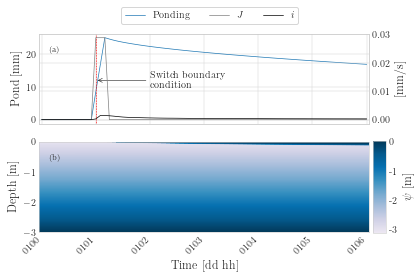

In [4]:
line_w = 0.7

start_date = '2017-01-01 00:00'
end_date = '2017-01-01 06:00'

plot_width = 15/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds_wet.time.sel(time=slice(start_date, end_date)).values, ds_wet.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds_wet.time.sel(time=slice(start_date, end_date)).values, ds_wet.topBC.sel(time=slice(start_date,end_date))/300, label='$J$', linewidth=line_w, color='0.5')
lns3 = ax0twin.plot(ds_wet.time.sel(time=slice(start_date, end_date)).values, abs(ds_wet.darcyVelocity.sel(dualDepth=0).sel(time=slice(start_date,end_date)))*1000, label='$i$', color='0.', linewidth=line_w)


ax0twin.set_ylabel('[mm/s]')
ax[0].set_ylabel('Pond [mm]')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.8,1.35) , ncol=3)


norm = matplotlib.colors.Normalize(vmin=-3.1, vmax=0.02)
im = ds_wet.psi.sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$\psi$ [m]', ticks=[-3, -2,  -1, 0.0])
cbar.ax.set_yticklabels(['-3', '-2', '-1', ' 0'])



## text plot
ax[0].axvline(x=ds_wet.time.sel(time='2017-01-01 01:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
ax[0].annotate(s='Switch boundary\ncondition', fontsize=10, xy=(ds_wet.time.sel(time='2017-01-01 01:00').values,12), xytext=(ds_wet.time.sel(time='2017-01-01 02:00').values,12), arrowprops={'arrowstyle':'->','lw': 0.5, 'ec': 'k'}, va='center')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=8,
             transform=ax[0].transAxes)
plt.text( 0.03,0.8, '(b)', fontsize=8,
             transform=ax[1].transAxes)


plt.show()

### 'Dry' case

Panel (a) shows a comparison between the rainfall intensity $J$ and actual soil infiltration $i$. The rainfall intensity exceeds the
actual infiltration rate so water builds up at the soil surface (blue line). Panel (b) shows the time evolution of the water suction within the
soil. From the numerical point of view, as water builds up at the soil surface it would be necessary to switch the boundary condition, from
Neumann type to Dirichlet type.

In [ ]:
line_w = 0.7

start_date = '2017-01-01 00:00'
end_date = '2017-01-01 06:00'

plot_width = 15/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds_dry.time.sel(time=slice(start_date, end_date)).values, ds_dry.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds_dry.time.sel(time=slice(start_date, end_date)).values, ds_dry.topBC.sel(time=slice(start_date,end_date))/300, label='$J$', linewidth=line_w, color='0.5')
lns3 = ax0twin.plot(ds_dry.time.sel(time=slice(start_date, end_date)).values, abs(ds_dry.darcyVelocity.sel(dualDepth=0).sel(time=slice(start_date,end_date)))*1000, label='$i$', color='0.', linewidth=line_w)


ax0twin.set_ylabel('[mm/s]')
ax[0].set_ylabel('Pond [mm]')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.8,1.35) , ncol=3)


norm = matplotlib.colors.Normalize(vmin=-100, vmax=0.02)
im = ds_dry.psi.sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$\psi$ [m]')


## text plot
ax[0].axvline(x=ds_dry.time.sel(time='2017-01-01 01:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
ax[0].annotate(s='Switch boundary\ncondition', fontsize=10, xy=(ds_dry.time.sel(time='2017-01-01 01:00').values,12), xytext=(ds_dry.time.sel(time='2017-01-01 02:00').values,12), arrowprops={'arrowstyle':'->','lw': 0.5, 'ec': 'k'}, va='center')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=8,
             transform=ax[0].transAxes)
plt.text( 0.03,0.8, '(b)', fontsize=8,
             transform=ax[1].transAxes)


plt.show()

## Comparison between the 'wet' and 'dry' soil

Panel (a) shows a comparison between the infiltration rate for two cases: wet and dry initial condition. In the dry case, soil
infiltration is greater than the wet case even though the hydraulic conductivity is smaller. This is due to the higher capillary gradients that
develop in the soil. Panel (b) shows the time evolution of the water ponding at the soil surface.

In [ ]:
line_w = 0.7

start_date = '2017-01-01 00:00'
end_date = '2017-01-02 23:00'

plot_width = 15/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds_wet.time.sel(time=slice(start_date, end_date)).values, abs(ds_wet.darcyVelocity.sel(dualDepth=0).sel(time=slice(start_date,end_date)))*1000, label='Wet soil', linewidth=line_w, color='#1f78b4')
lns2 = ax[0].plot(ds_dry.time.sel(time=slice(start_date, end_date)).values, abs(ds_dry.darcyVelocity.sel(dualDepth=0).sel(time=slice(start_date,end_date)))*1000, label='Dry soil', color='#33a02c', linewidth=line_w)

ax[0].set_ylabel('$i$ [mm/s]')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.76,1.35) , ncol=3)


lns1 = ax[1].plot(ds_wet.time.sel(time=slice(start_date, end_date)).values, abs(ds_wet.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date)))*1000, linewidth=line_w, color='#1f78b4')
lns2 = ax[1].plot(ds_dry.time.sel(time=slice(start_date, end_date)).values, abs(ds_dry.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date)))*1000,  color='#33a02c', linewidth=line_w)
ax[1].set_ylabel('Ponding [mm]')
ax[1].set_xlabel('Time [dd hh]')



ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.9,0.8, '(a)', fontsize=8,
             transform=ax[0].transAxes)
plt.text( 0.9,0.8, '(b)', fontsize=8,
             transform=ax[1].transAxes)


plt.show()


With regards to the water ponding, the maximum value is almost the same in both
cases, $1$ [mm] higher in the wet case, but the time evolution is different: in the wet case the water only infiltrates completely
$13$ [h] later than the dry case. This delay may seem counter-intuitive since wetter conditions are associated with higher values
of hydraulic conductivity, but in the wet soil the capillary gradients are smaller than in the dry soil.

## Comparison between the capillary gradient field for the 'wet' and 'dry' soil

### Compute the capillary gradient field for the 'wet' and 'dry' soil

In [ ]:
start_date = '2017-01-01 00:00'
end_date = '2017-01-02 23:55'

gradient_wet = np.zeros((576,601))
gradient_wet[:,1:] = (ds_wet.psi.values[:,1:]-ds_wet.psi.values[:,0:-1])/(ds_wet.depth.values[1:]-ds_wet.depth.values[0:-1])    # np.append(-3,ds_w.depth.values[0:-1]))

gradient_dry = np.zeros((576,601))
gradient_dry[:,1:] = (ds_dry.psi.values[:,1:]-ds_dry.psi.values[:,0:-1])/(ds_dry.depth.values[1:]-ds_dry.depth.values[0:-1])    # np.append(-3,ds_w.depth.values[0:-1]))

ds_wet['gradient'] = (['time', 'dualDepth'], gradient_wet)
ds_dry['gradient'] = (['time', 'dualDepth'], gradient_dry)

In [ ]:
line_w = 0.7

start_date = '2017-01-01 00:00'
end_date = '2017-01-03 00:00'

plot_width = 15/2.54


fig, ax = plt.subplots(2, 1, sharex='col', figsize=(plot_width,plot_width/1.618))

norm = matplotlib.colors.Normalize(vmin=np.amin(ds_wet.gradient.sel(time=slice(start_date, end_date))), vmax=np.amax(ds_wet.gradient.sel(time=slice(start_date, end_date))))
im = ds_wet.gradient.sel(time=slice(start_date, end_date)).sel(dualDepth=slice(-0.2, 0)).plot(ax=ax[0], y='dualDepth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[0].xaxis.set_tick_params(rotation=45)

cbaxes = fig.add_axes([0.91, 0.53, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[0],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$\\nabla \psi$ [-]',  format='%.0e')


norm = matplotlib.colors.Normalize(vmin=np.amin(ds_dry.gradient.sel(time=slice(start_date, end_date))), vmax=np.amax(ds_dry.gradient.sel(time=slice(start_date, end_date))))
im = ds_dry.gradient.sel(time=slice(start_date, end_date)).sel(dualDepth=slice(-0.2, 0)).plot(ax=ax[1], y='dualDepth', add_colorbar=False, cmap=my_cmap, norm=norm)                                            
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$\\nabla \psi$ [-]', format='%.0e')


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.2, '(a)', fontsize=8,
             transform=ax[0].transAxes)
plt.text( 0.03,0.2, '(b)', fontsize=8,
             transform=ax[1].transAxes)


plt.show()
# fig.savefig('Horton_grad.pdf', format='pdf', bbox_inches='tight')

Panel (a) shows the capillary gradient for the case of 'wet' soil, panel (b) shows the the capillary gradient for the case of 'dry' soil.
As can be seen, in the 'dry' soil the capillary gradient is two orders of magnitude larger than in the 'wet' soil. Because of this higher gradient
water infiltrates faster in the 'dry' soil than in the 'wet' soil.

## Comparison between the hydraulic conductivity field for the 'wet' and 'dry' soil

### Compute the hydraulic conductivity field for the 'wet' and 'dry' soil

In [ ]:
i = 2
theta_r = 0.089
theta_s = 0.43
par_1 = 1.23
par_2 = 1
ks = 1.9447e-07
theta = lambda x: theta_r +(theta_s-theta_r)*1/(1+abs(par_2*x)**par_1)**(1-1/par_1) if x<0 else theta_s
Se = lambda x: (theta(x)-theta_r)/(theta_s-theta_r) if x<0 else 1
k = lambda x: ks*Se(x)**0.5 *(1-(1-Se(x)**(1/(1-1/par_1)))**(1-1/par_1))**2 if x<0 else ks

k_wet = np.zeros((576,601))
k_dry = np.zeros((576,601))
k_vec = np.vectorize(k)

k_wet[:,:-1] = k_vec(ds_wet.psi.values[:,:-1])
k_dry[:,:-1] = k_vec(ds_dry.psi.values[:,:-1])

ds_wet['k'] = (['time', 'depth'], k_wet)
ds_dry['k'] = (['time', 'depth'], k_dry)

In [ ]:
line_w = 0.7

start_date = '2017-01-01 00:00'
end_date = '2017-01-03 00:00'

plot_width = 15/2.54


fig, ax = plt.subplots(2, 1, sharex='col', figsize=(plot_width,plot_width/1.618))

norm = matplotlib.colors.Normalize(vmin=np.amin(ds_wet.k.values), vmax=np.amax(ds_wet.k.values))
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(ds_wet.k.values))

im = (ds_wet.k.sel(time=slice(start_date, end_date)).sel(depth=slice(-0.2, -0.0025))).plot(ax=ax[0], y='depth', add_colorbar=False, cmap=my_cmap)  
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[0].xaxis.set_tick_params(rotation=45)

cbaxes = fig.add_axes([0.91, 0.53, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.07, pad=0.1, cax=cbaxes, label='$\psi$ [m]', format='%.0e', ticks=[5e-8, 1e-7, 1.5e-7])
cbar.ax.set_yticklabels(['0.5e-07', '1e-07', '1.5e-07'])


norm = matplotlib.colors.Normalize(vmin=(np.amin(ds_dry.k.values)), vmax=(np.amax(ds_dry.k.values)))
im = (ds_dry.k.sel(time=slice(start_date, end_date)).sel(depth=slice(-0.2, -0.0025))).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap)  
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[0],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$K(\psi)$ [m/s]', format='%.0e',ticks=[5e-8, 1e-7, 1.5e-7])
cbar.ax.set_yticklabels(['0.5e-07', '1e-07', '1.5e-07'])


ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.2, '(a)', fontsize=8,
             transform=ax[0].transAxes)
plt.text( 0.03,0.2, '(b)', fontsize=8,
             transform=ax[1].transAxes)


plt.show()

Panel (a) shows the hydraulic conductivity field for the case of 'wet' soil, while panel (b) shows the hydraulic conductivity field
for the case of 'dry' soil.